In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
file = "/content/goldstock.csv"
df = pd.read_csv(file)
df.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,Date,Close,Volume,Open,High,Low
0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


<Figure size 1500x800 with 0 Axes>

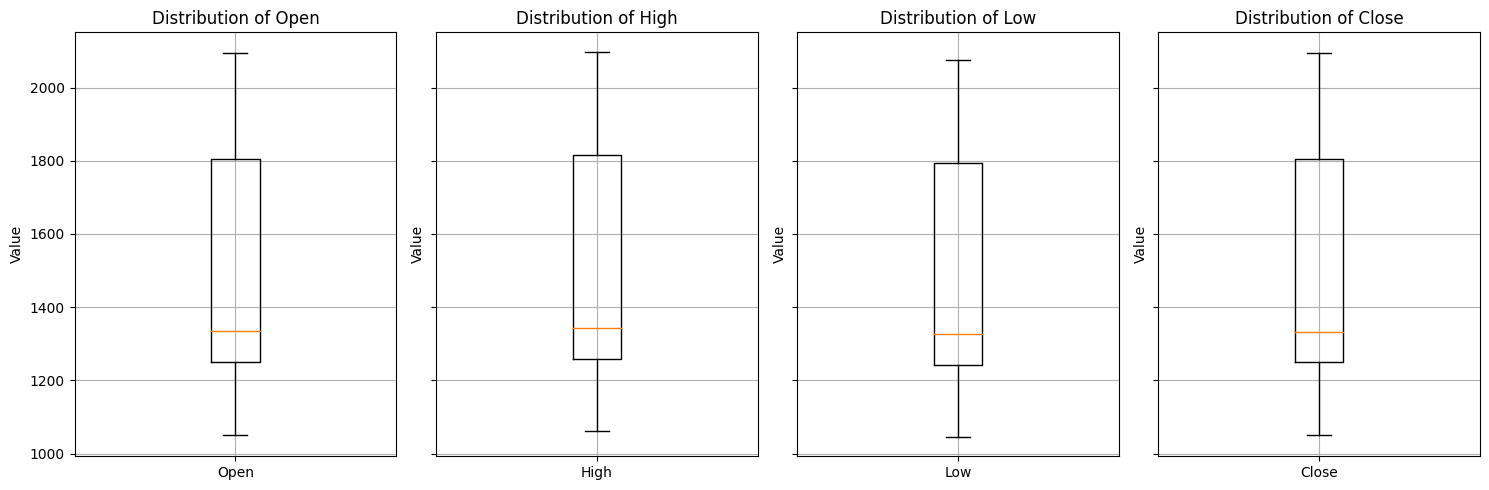

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

features_to_plot = ['Open', 'High', 'Low', 'Close']
num_features = len(features_to_plot)

# Create subplots
fig, axes = plt.subplots(1, num_features, figsize=(15, 5), sharey=True)

for i, feature in enumerate(features_to_plot):
    axes[i].boxplot(df[feature])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_ylabel('Value')
    axes[i].set_xticks([1])
    axes[i].set_xticklabels([feature])
    axes[i].grid(True)

plt.tight_layout()
plt.show()


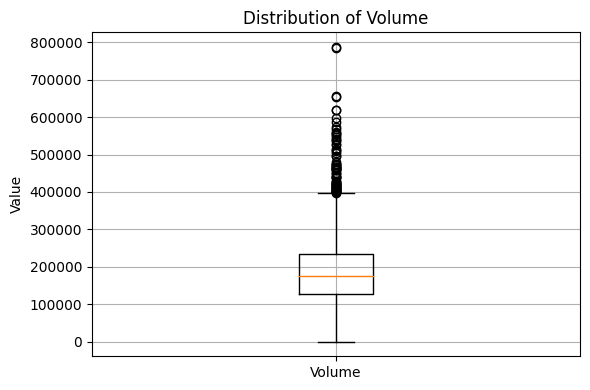

In [5]:
plt.figure(figsize=(6, 4))
plt.boxplot(df['Volume'])
plt.title('Distribution of Volume')
plt.ylabel('Value')
plt.xticks([1], ['Volume'])
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-6-3379cd56d408>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


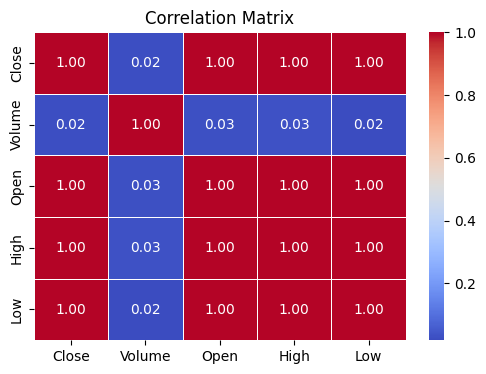

In [6]:
correlation_matrix = df.corr()

plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [7]:
data = df
backup = data

In [8]:
backup.head()

,Date,Close,Volume,Open,High,Low
0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


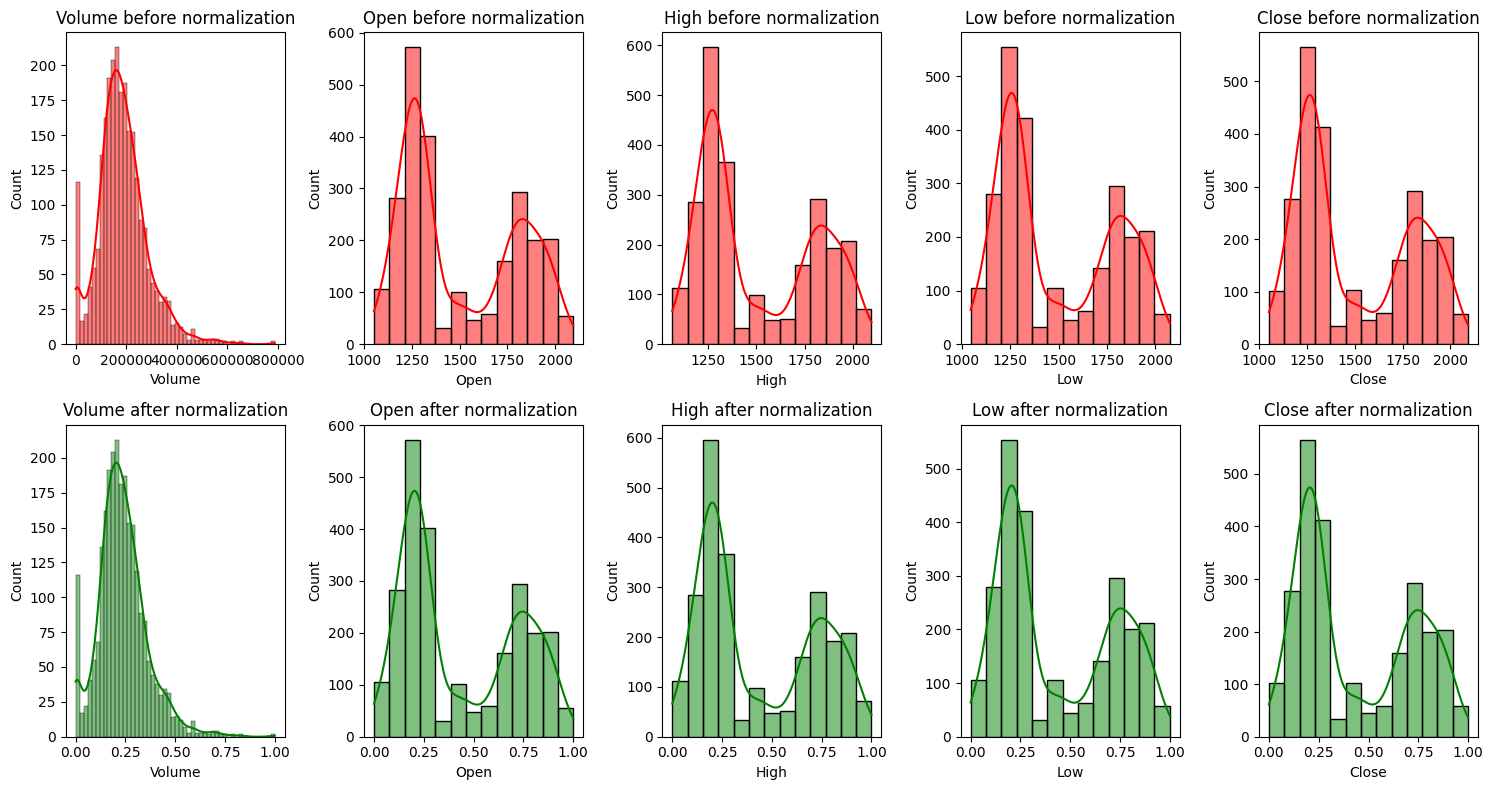

In [9]:
scaler = MinMaxScaler()
columns_to_normalize = ['Volume', 'Open', 'High', 'Low', 'Close']

plt.figure(figsize=(15, 8))
for i, col in enumerate(columns_to_normalize):
    plt.subplot(2, len(columns_to_normalize), i+1)
    sns.histplot(df[col], kde=True, color='red')
    plt.title(f'{col} before normalization')

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

for i, col in enumerate(columns_to_normalize):
    plt.subplot(2, len(columns_to_normalize), len(columns_to_normalize) + i + 1)
    sns.histplot(df[col], kde=True, color='green')
    plt.title(f'{col} after normalization')

plt.tight_layout()
plt.show()

In [10]:
df = pd.read_csv(file)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,Date,Close,Volume,Open,High,Low
0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [11]:
df.isna().sum()

Date      0
Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64

In [12]:
df.describe()

,Close,Volume,Open,High,Low
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,1498.726085,185970.770609,1498.725528,1508.451454,1488.869932
std,298.824811,97600.769382,299.118187,301.262244,296.417703
min,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,1249.850000,126693.500000,1249.500000,1257.300000,1242.350000
50%,1332.800000,175421.000000,1334.000000,1342.400000,1326.600000
75%,1805.850000,234832.000000,1805.600000,1815.450000,1793.050000
max,2093.100000,787217.000000,2094.400000,2098.200000,2074.600000


In [17]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [13]:
df.head()

,Date,Close,Volume,Open,High,Low
0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [16]:
df['Date'] = pd.to_datetime(df['Date'])

In [17]:
monthly_avg = df.groupby(df['Date'].dt.to_period('M')).mean()

<ipython-input-17-a31e4e41a2c7>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_avg = df.groupby(df['Date'].dt.to_period('M')).mean()


In [19]:
df = monthly_avg

In [20]:
df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2014-01,1253.012500,85435.250000,1253.962500,1264.887500,1243.400000
2014-02,1300.721053,119566.526316,1298.015789,1307.473684,1290.257895
2014-03,1336.528571,131182.666667,1334.738095,1346.000000,1326.633333
2014-04,1298.747619,111595.380952,1297.095238,1306.490476,1290.047619
2014-05,1287.809524,114173.285714,1290.266667,1296.895238,1280.761905


In [21]:
Close_df = df[['Close']]

In [22]:
Close_df.head()

,Close
Date,
2014-01,1253.012500
2014-02,1300.721053
2014-03,1336.528571
2014-04,1298.747619
2014-05,1287.809524


In [23]:
Close_df.isna().sum()

Close    0
dtype: int64

In [24]:
Close_df.describe()

,Close
count,121.000000
mean,1498.958374
std,299.358352
min,1068.586364
25%,1245.854545
50%,1333.776190
75%,1807.623810
max,2046.035000


<Axes: xlabel='Date'>

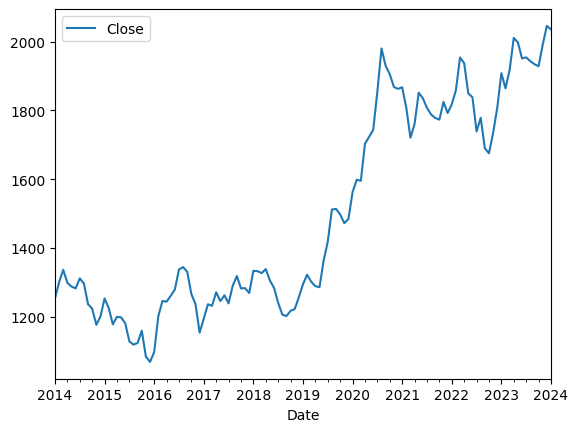

In [25]:
Close_df.plot()

In [26]:
Close_test_result=adfuller(Close_df['Close'])

In [27]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [28]:
adfuller_test(Close_df['Close'])

ADF Test Statistic : -0.36897095314633593
p-value : 0.9151520361270042
#Lags Used : 1
Number of Observations Used : 119
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [29]:
Close_df['Close First Difference'] = Close_df['Close'] - Close_df['Close'].shift(1)

<ipython-input-29-8d4c4d1e5b3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Close_df['Close First Difference'] = Close_df['Close'] - Close_df['Close'].shift(1)


In [30]:
Close_df['Close'].shift(1)

Date
2014-01            NaN
2014-02    1253.012500
2014-03    1300.721053
2014-04    1336.528571
2014-05    1298.747619
              ...     
2023-09    1943.469565
2023-10    1934.715000
2023-11    1928.622727
2023-12    1991.190476
2024-01    2046.035000
Freq: M, Name: Close, Length: 121, dtype: float64

In [31]:
Close_df['Close Seasonal First Difference']=Close_df['Close'] - Close_df['Close'].shift(12)

<ipython-input-31-26a16bfcd70f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Close_df['Close Seasonal First Difference']=Close_df['Close'] - Close_df['Close'].shift(12)


In [32]:
Close_df.head()

,Close,Close First Difference,Close Seasonal First Difference
Date,,,
2014-01,1253.012500,NaN,NaN
2014-02,1300.721053,47.708553,NaN
2014-03,1336.528571,35.807519,NaN
2014-04,1298.747619,-37.780952,NaN
2014-05,1287.809524,-10.938095,NaN


In [33]:
adfuller_test(Close_df['Close First Difference'].dropna())

ADF Test Statistic : -8.867638829844218
p-value : 1.426089245809756e-14
#Lags Used : 0
Number of Observations Used : 119
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [32]:
adfuller_test(Close_df['Close Seasonal First Difference'].dropna())

ADF Test Statistic : -7.541745085989653
p-value : 3.363926709902672e-11
#Lags Used : 24
Number of Observations Used : 2474
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Date'>

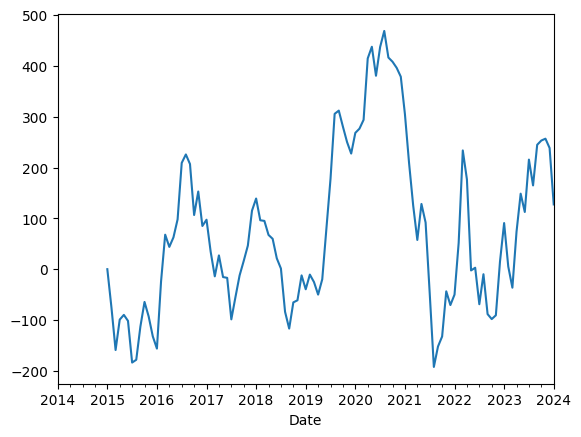

In [34]:
Close_df['Close Seasonal First Difference'].plot()

<Axes: xlabel='Date'>

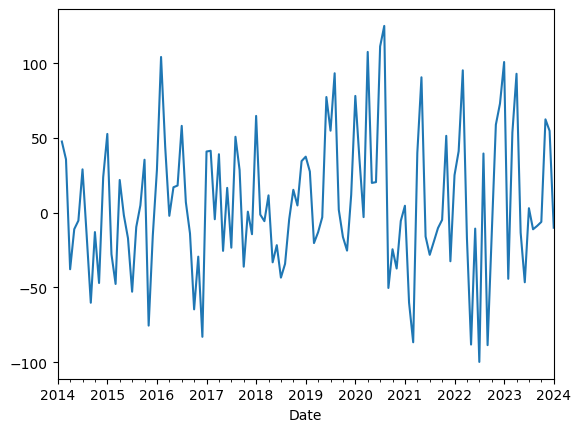

In [35]:
Close_df['Close First Difference'].plot()

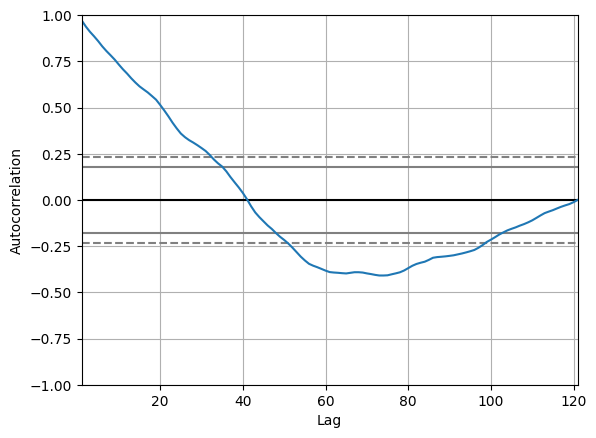

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

pd.plotting.autocorrelation_plot(Close_df['Close'])
plt.show()

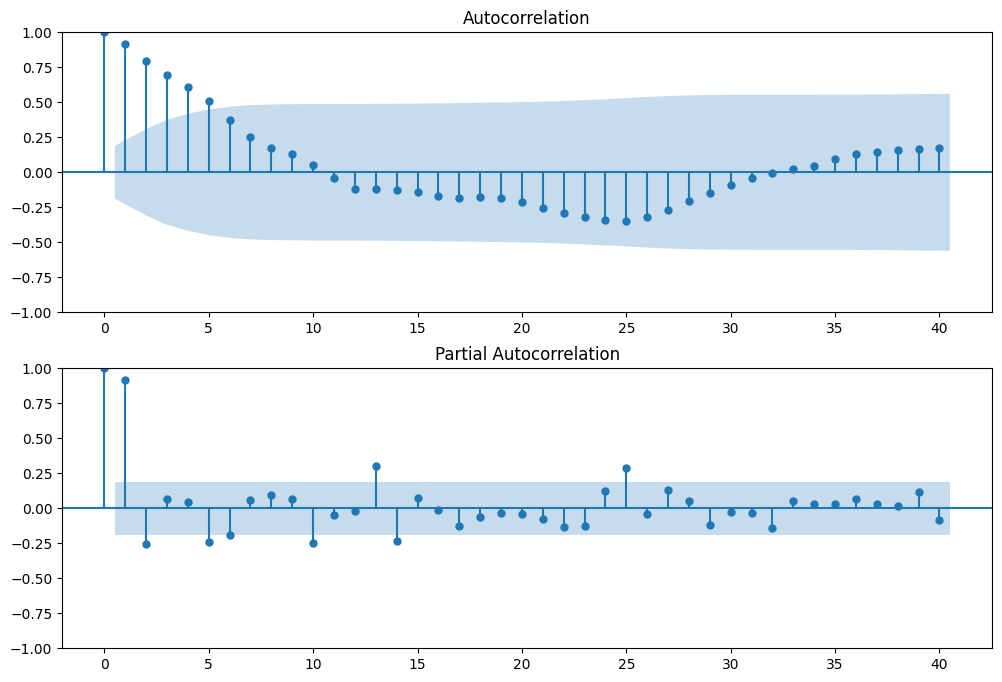

In [37]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Close_df['Close Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Close_df['Close Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

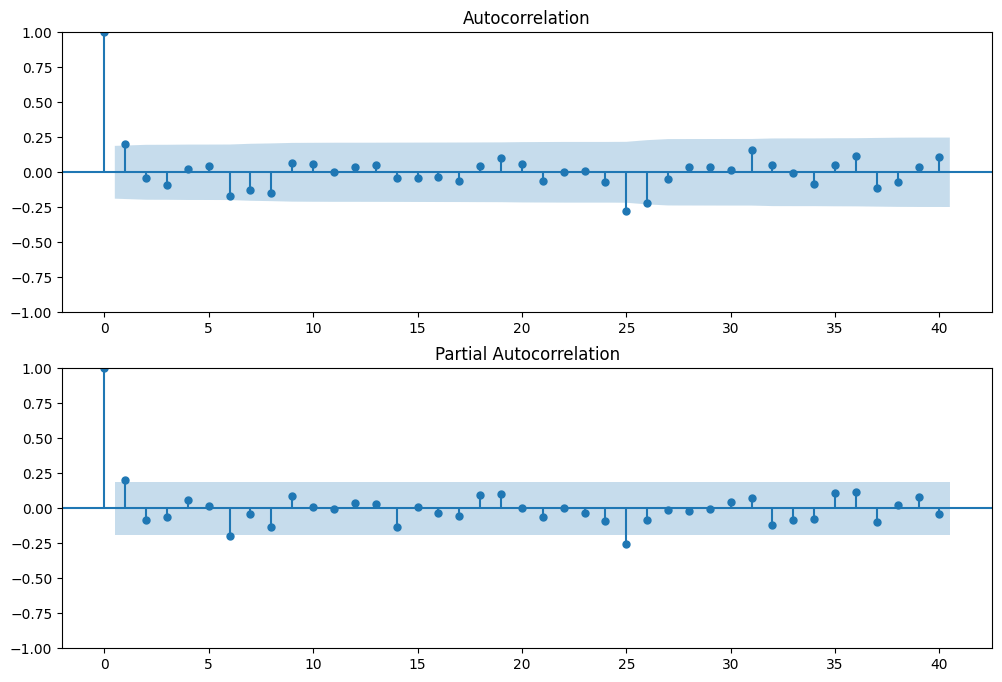

In [38]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Close_df['Close First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Close_df['Close First Difference'].iloc[13:],lags=40,ax=ax2)

In [51]:
Close_S_model=sm.tsa.statespace.SARIMAX(Close_df['Close First Difference'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=Close_S_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [43]:
Close_df.index = Close_df.index.to_timestamp()

In [44]:
Close_df.index = pd.date_range(start=Close_df.index[0], periods=len(Close_df), freq='M')

In [45]:
from pandas.tseries.offsets import DateOffset
future_dates=[Close_df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [46]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=Close_df.columns)

In [47]:
future_datest_df.tail()

,Close,Close First Difference,Close Seasonal First Difference,Close forecast
2025-08-31,NaN,NaN,NaN,NaN
2025-09-30,NaN,NaN,NaN,NaN
2025-10-31,NaN,NaN,NaN,NaN
2025-11-30,NaN,NaN,NaN,NaN
2025-12-31,NaN,NaN,NaN,NaN


In [48]:
future_df=pd.concat([Close_df,future_datest_df])

In [49]:
future_df.head()

,Close,Close First Difference,Close Seasonal First Difference,Close forecast
2014-01-31,1253.012500,NaN,NaN,NaN
2014-02-28,1300.721053,47.708553,NaN,NaN
2014-03-31,1336.528571,35.807519,NaN,NaN
2014-04-30,1298.747619,-37.780952,NaN,NaN
2014-05-31,1287.809524,-10.938095,NaN,NaN


<Axes: >

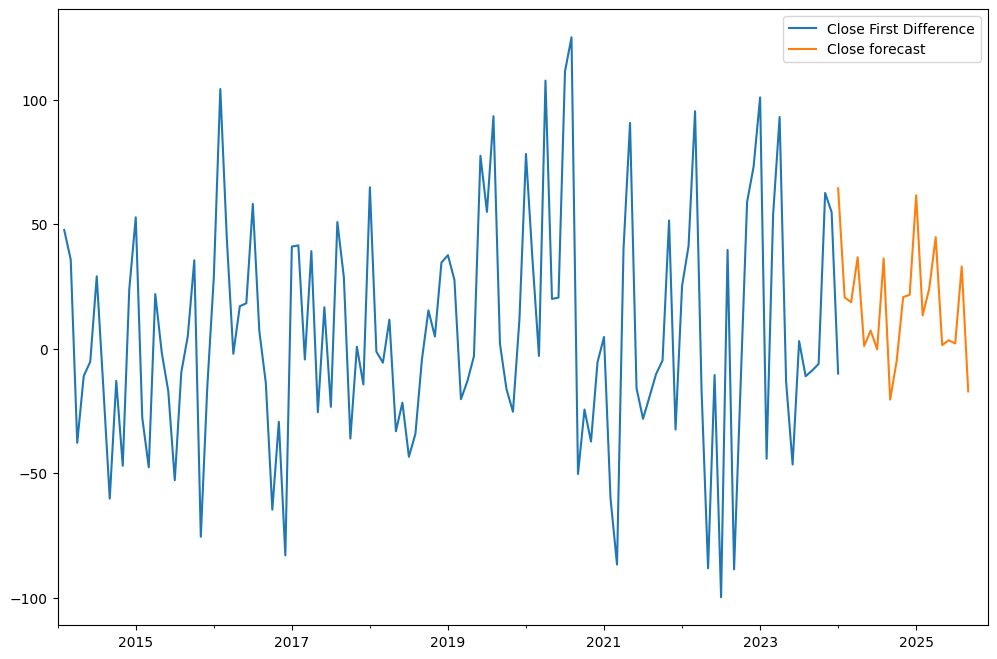

In [52]:
future_df['Close forecast'] = results.predict(start = 120, end = 140, dynamic= True)
future_df[['Close First Difference', 'Close forecast']].plot(figsize=(12, 8))

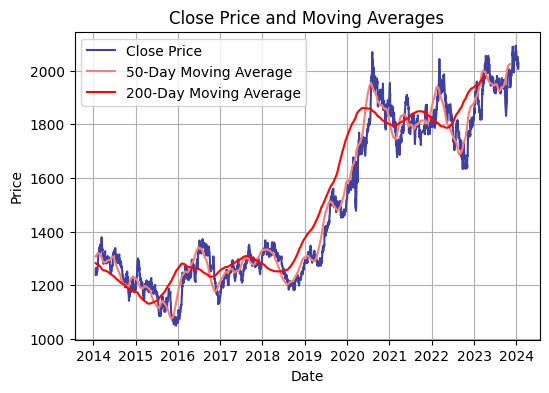

In [57]:
window_1 = 50
window_2 = 200
close_prices_ma_1 = df['Close'].rolling(window=window_1).mean()
close_prices_ma_2 = df['Close'].rolling(window=window_2).mean()

# Plot the prices and moving averages with different colors
plt.figure(figsize=(6, 4))
plt.plot(df.index, df['Close'], label="Close Price", color='#4040a1')
plt.plot(df.index, close_prices_ma_1, label="50-Day Moving Average", color='Salmon')
plt.plot(df.index, close_prices_ma_2, label="200-Day Moving Average", color='red')
plt.title('Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Day'] = df.index.day

In [59]:
df.head()

,Unnamed: 0,Close,Volume,Open,High,Low,Month,Year,Day
Date,,,,,,,,,
2024-01-19,0,2029.3,166078.0,2027.4,2041.9,2022.2,1,2024,19
2024-01-18,1,2021.6,167013.0,2009.1,2025.6,2007.7,1,2024,18
2024-01-17,2,2006.5,245194.0,2031.7,2036.1,2004.6,1,2024,17
2024-01-16,3,2030.2,277995.0,2053.4,2062.8,2027.6,1,2024,16
2024-01-12,4,2051.6,250946.0,2033.2,2067.3,2033.1,1,2024,12


<ipython-input-64-13a78a8c53d3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Day', y='Close', data=df.groupby('Day')['Close'].mean().reset_index(), palette="husl")


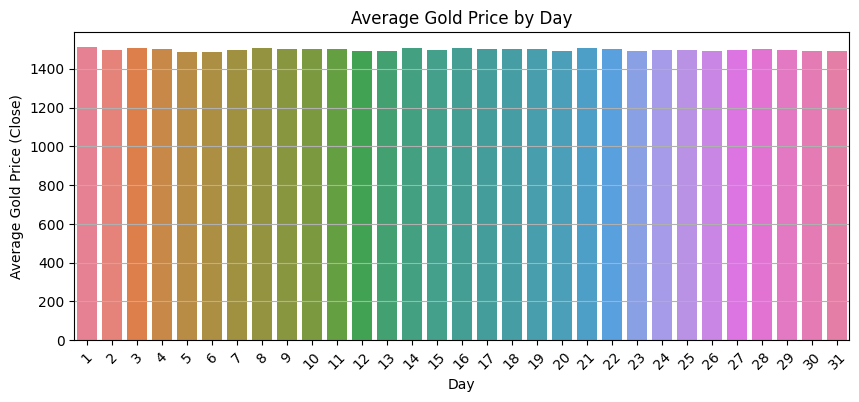

In [64]:
plt.figure(figsize=(10,4))
sns.barplot(x='Day', y='Close', data=df.groupby('Day')['Close'].mean().reset_index(), palette="husl")
plt.title('Average Gold Price by Day')
plt.xlabel('Day')
plt.ylabel('Average Gold Price (Close)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

<ipython-input-63-0938ebab9830>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Close', data=df.groupby('Month')['Close'].mean().reset_index(), palette="husl")


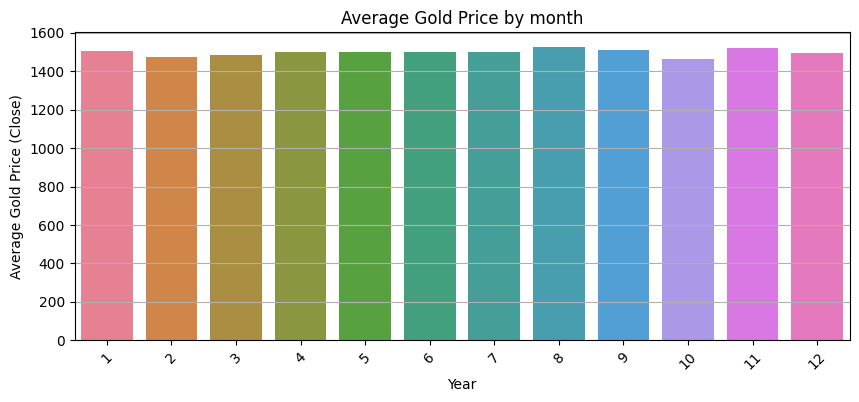

In [63]:
plt.figure(figsize=(10,4))
sns.barplot(x='Month', y='Close', data=df.groupby('Month')['Close'].mean().reset_index(), palette="husl")
plt.title('Average Gold Price by month')
plt.xlabel('Year')
plt.ylabel('Average Gold Price (Close)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

<ipython-input-61-5227ef88079f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Close', data=df.groupby('Year')['Close'].mean().reset_index(), palette="husl")


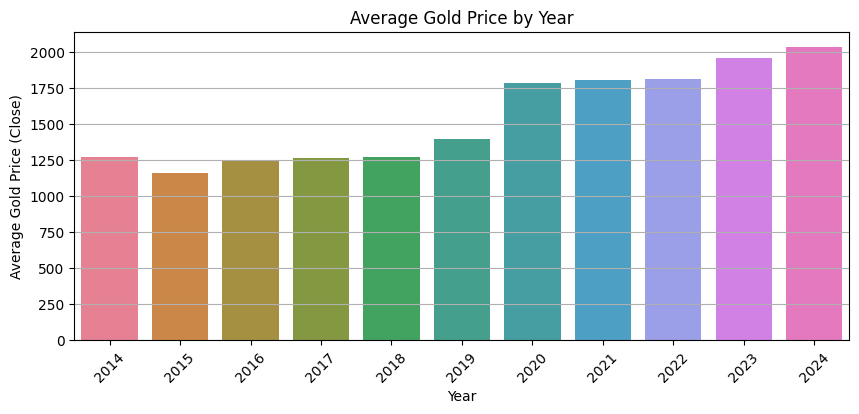

In [61]:
plt.figure(figsize=(10,4))
sns.barplot(x='Year', y='Close', data=df.groupby('Year')['Close'].mean().reset_index(), palette="husl")
plt.title('Average Gold Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Gold Price (Close)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

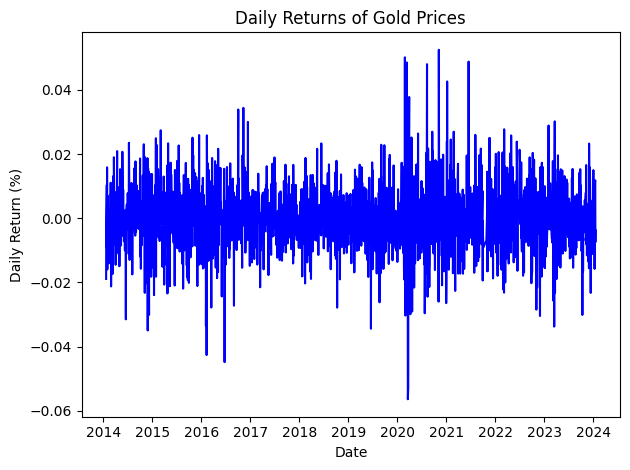

In [65]:
daily_returns = df['Close'].pct_change()

# Plot the daily returns
plt.plot(daily_returns.index, daily_returns,color='blue')
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.title("Daily Returns of Gold Prices")
plt.tight_layout()
plt.show()

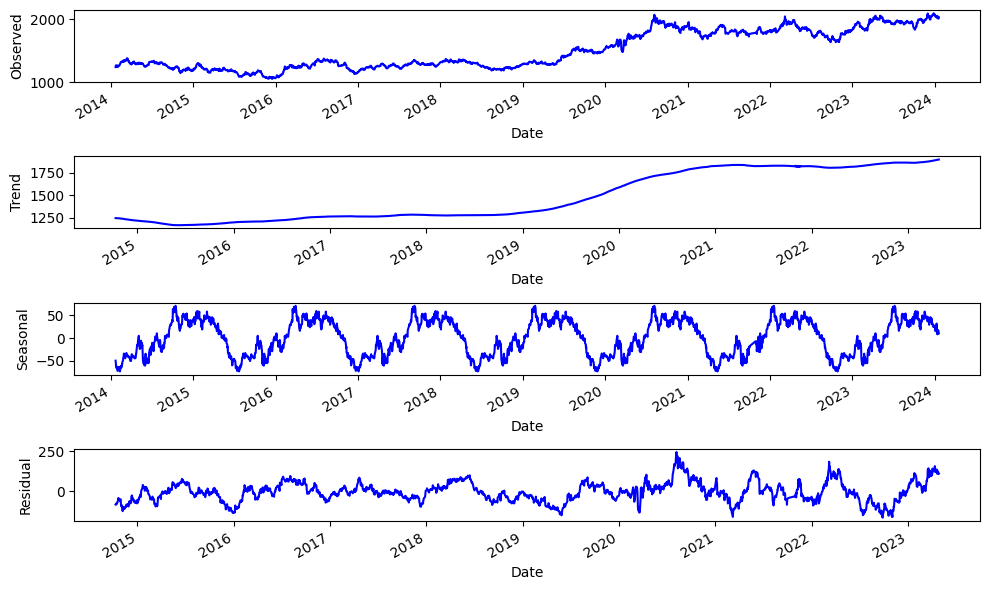

In [66]:
result = seasonal_decompose(df['Close'], model='additive', period=365)
fig, axes = plt.subplots(4, 1, figsize=(10, 6))

# Plot each component and set the color to blue
result.observed.plot(ax=axes[0], color='blue')
axes[0].set_ylabel('Observed')

result.trend.plot(ax=axes[1], color='blue')
axes[1].set_ylabel('Trend')

result.seasonal.plot(ax=axes[2], color='blue')
axes[2].set_ylabel('Seasonal')

result.resid.plot(ax=axes[3], color='blue')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

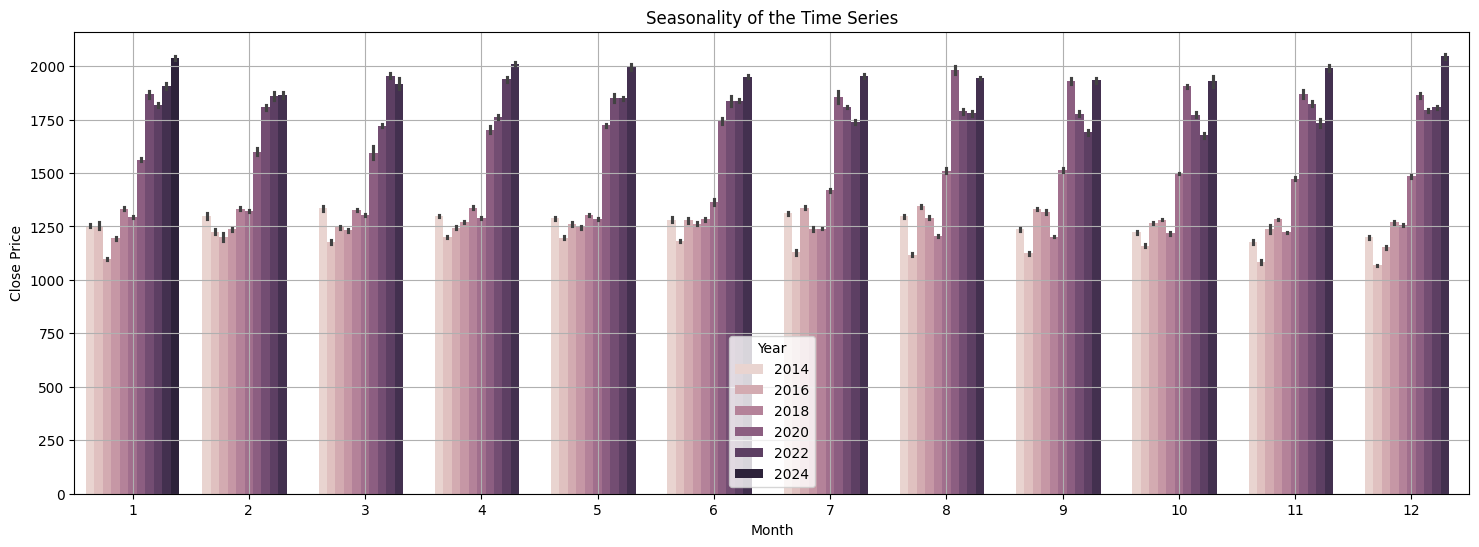

In [67]:
plt.figure(figsize=(18,6))
plt.title('Seasonality of the Time Series')

sns.barplot(x='Month', y='Close', hue='Year', data=df)

plt.xlabel('Month')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

<ipython-input-68-d0e0c671fb1d>:52: RuntimeWarning: invalid value encountered in divide
  daily_returns = np.diff(portfolio_value) / portfolio_value[:-1]


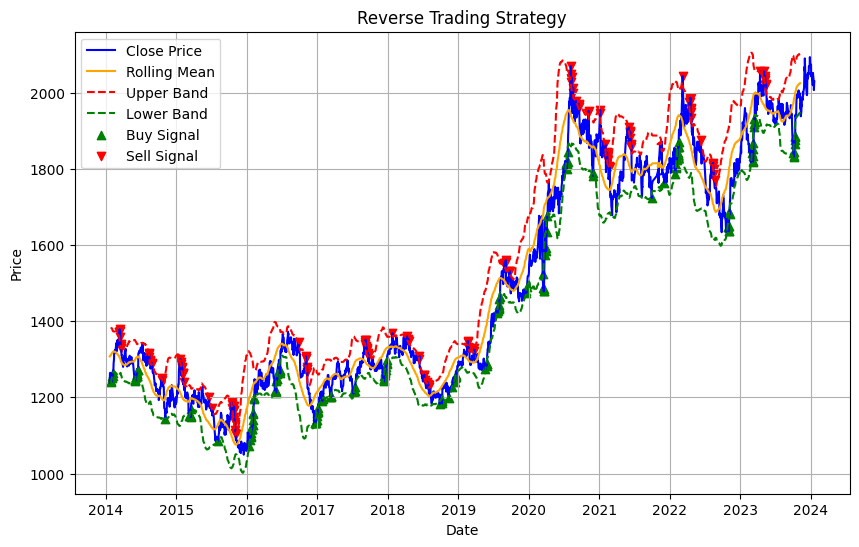

In [68]:
lookback_period = 50
entry_threshold = 2.0
exit_threshold = 0.0

df['RollingMean'] = df['Close'].rolling(window=lookback_period).mean()
df['RollingStd'] = df['Close'].rolling(window=lookback_period).std()

# Calculate upper and lower bands for entry and exit
df['UpperBand'] = df['RollingMean'] + entry_threshold * df['RollingStd']
df['LowerBand'] = df['RollingMean'] - entry_threshold * df['RollingStd']
exit_band = df['RollingMean'] + exit_threshold * df['RollingStd']

# Initialize trading signals
df['Signal'] = 0

# Generate trading signals
for i in range(lookback_period, len(df)):
    if df['Close'].iloc[i] > df['UpperBand'].iloc[i]:
        df.at[df.index[i], 'Signal'] = -1  # Sell signal (price above upper band)
    elif df['Close'].iloc[i] < df['LowerBand'].iloc[i]:
        df.at[df.index[i], 'Signal'] = 1  # Buy signal (price below lower band)
    elif df['Close'].iloc[i] > exit_band.iloc[i]:
        df.at[df.index[i], 'Signal'] = 0  # Exit signal (price above exit band)
    elif df['Close'].iloc[i] < exit_band.iloc[i]:
        df.at[df.index[i], 'Signal'] = 0  # Exit signal (price below exit band)

# Backtesting
initial_capital = 100000  # Initial capital in dollars
position = 0  # Initial position
cash = initial_capital  # Initial cash
portfolio_value = []  # Portfolio value over time

for i in range(lookback_period, len(df)):
    if df['Signal'].iloc[i] == 1:
        # Enter long position
        position = cash / df['Close'].iloc[i]  # Invest all available cash
        cash = 0  # No remaining cash after buying
    elif df['Signal'].iloc[i] == -1:
        # Enter short position
        cash += position * df['Close'].iloc[i]  # Sell all owned assets
        position = 0  # No remaining position after selling
    elif df['Signal'].iloc[i] == 0:
        # Exit position
        cash += position * df['Close'].iloc[i]  # Sell all owned assets
        position = 0  # No remaining position after selling

    # Calculate portfolio value
    portfolio_value.append(cash + position * df['Close'].iloc[i])

# Calculate performance metrics
total_return = (portfolio_value[-1] - initial_capital) / initial_capital
daily_returns = np.diff(portfolio_value) / portfolio_value[:-1]
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days in a year
max_drawdown = np.max(np.maximum.accumulate(portfolio_value) - portfolio_value) / initial_capital

# Plotting
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['RollingMean'], label='Rolling Mean', color='orange')
plt.plot(df.index, df['UpperBand'], label='Upper Band', color='red', linestyle='--')
plt.plot(df.index, df['LowerBand'], label='Lower Band', color='green', linestyle='--')

# Filter 'Close' prices for buy and sell signals
buy_indices = df[df['Signal'] == 1].index
sell_indices = df[df['Signal'] == -1].index
buy_prices = df.loc[df['Signal'] == 1, 'Close']
sell_prices = df.loc[df['Signal'] == -1, 'Close']

# Plot buy and sell signals
plt.scatter(buy_indices, buy_prices, label='Buy Signal', marker='^', color='green')
plt.scatter(sell_indices, sell_prices, label='Sell Signal', marker='v', color='red')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Reverse Trading Strategy')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
# Count the number of buy and sell signals
total_trades = len(df[df['Signal'] != 0])

# Count the number of successful buy and sell signals
successful_buy_trades = len(df[(df['Signal'] == 1) & (df['Close'] < df['UpperBand'])])
successful_sell_trades = len(df[(df['Signal'] == -1) & (df['Close'] > df['LowerBand'])])

# Calculate win rates
buy_win_rate = successful_buy_trades / total_trades
sell_win_rate = successful_sell_trades / total_trades

# Print win rates
print("Buy Win Rate:", buy_win_rate)
print("Sell Win Rate:", sell_win_rate)

Buy Win Rate: 0.5304878048780488
Sell Win Rate: 0.4695121951219512


In [70]:
df.head()

,Unnamed: 0,Close,Volume,Open,High,Low,Month,Year,Day,RollingMean,RollingStd,UpperBand,LowerBand,Signal
Date,,,,,,,,,,,,,,
2024-01-19,0,2029.3,166078.0,2027.4,2041.9,2022.2,1,2024,19,NaN,NaN,NaN,NaN,0
2024-01-18,1,2021.6,167013.0,2009.1,2025.6,2007.7,1,2024,18,NaN,NaN,NaN,NaN,0
2024-01-17,2,2006.5,245194.0,2031.7,2036.1,2004.6,1,2024,17,NaN,NaN,NaN,NaN,0
2024-01-16,3,2030.2,277995.0,2053.4,2062.8,2027.6,1,2024,16,NaN,NaN,NaN,NaN,0
2024-01-12,4,2051.6,250946.0,2033.2,2067.3,2033.1,1,2024,12,NaN,NaN,NaN,NaN,0


In [71]:
columns_to_drop = ['RollingMean', 'RollingStd', 'UpperBand','LowerBand','Signal']
df.drop(columns=columns_to_drop, inplace=True)

In [72]:
df.head()

,Unnamed: 0,Close,Volume,Open,High,Low,Month,Year,Day
Date,,,,,,,,,
2024-01-19,0,2029.3,166078.0,2027.4,2041.9,2022.2,1,2024,19
2024-01-18,1,2021.6,167013.0,2009.1,2025.6,2007.7,1,2024,18
2024-01-17,2,2006.5,245194.0,2031.7,2036.1,2004.6,1,2024,17
2024-01-16,3,2030.2,277995.0,2053.4,2062.8,2027.6,1,2024,16
2024-01-12,4,2051.6,250946.0,2033.2,2067.3,2033.1,1,2024,12


In [73]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,Close,Volume,Open,High,Low,Month,Year,Day
Date,,,,,,,,
2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2,1,2024,19
2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7,1,2024,18
2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6,1,2024,17
2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6,1,2024,16
2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1,1,2024,12


In [74]:
df.reset_index(inplace=True)

In [75]:
df.head()

,Date,Close,Volume,Open,High,Low,Month,Year,Day
0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2,1,2024,19
1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7,1,2024,18
2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6,1,2024,17
3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6,1,2024,16
4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1,1,2024,12


In [76]:
df.to_csv('Final_gold.csv', index=False)